<h2 style="color: blue" align="center">Spaceship Titanic <h2/>


https://www.kaggle.com/competitions/spaceship-titanic

## Data Overview

**train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
<br>
**PassengerId**- A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
<br>
**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
<br>
**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
<br>
**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
<br>
**Destination** - The planet the passenger will be debarking to.
<br>
**Age** - The age of the passenger.
<br>
**VIP** - Whether the passenger has paid for special VIP service during the voyage.
<br>
**RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
<br>
**Name** - The first and last names of the passenger.
<br>
**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
<br>
test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.

### Purpose and assumptions:
1. No AI used for help
2. (no stack overflow/googling either), syntax errors purposes only
3. 6h of work for the entire project, 3x 2h sprints.
4. No code refactoring/storing everything in one notebook.
5. Trying to make an end-to-end project all by myself, using random kaggle competition, without prior data understanding.
6. Trying to explore my weak points and possibilites to growth.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

In [2]:
df_raw = pd.read_csv("data\\train.csv")
print("Shape before split: ",df_raw.shape)
df_raw.head()


Shape before split:  (8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
X = df_raw.drop("Transported", axis=1)
y = df_raw["Transported"]

X_train, X_val, y_train, y_val= train_test_split(X,y,random_state=1337, test_size=0.2)

print("Train shape: ", X_train.shape)
print("Val shape: ", X_val.shape)

Train shape:  (6954, 13)
Val shape:  (1739, 13)


In [4]:
df_train = pd.concat((X_train, y_train), axis=1)
df_train.shape

(6954, 14)

## Data Understanding

In [5]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6954 entries, 4049 to 3223
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6787 non-null   object 
 2   CryoSleep     6788 non-null   object 
 3   Cabin         6788 non-null   object 
 4   Destination   6812 non-null   object 
 5   Age           6810 non-null   float64
 6   VIP           6793 non-null   object 
 7   RoomService   6804 non-null   float64
 8   FoodCourt     6804 non-null   float64
 9   ShoppingMall  6798 non-null   float64
 10  Spa           6810 non-null   float64
 11  VRDeck        6813 non-null   float64
 12  Name          6805 non-null   object 
dtypes: float64(6), object(7)
memory usage: 760.6+ KB


In [6]:
X_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,6810.000000,6804.000000,6804.000000,6798.000000,6810.000000,6813.000000
mean,28.844347,219.848471,460.488536,172.003678,313.217621,313.176281
std,14.583124,661.642078,1618.347967,612.051347,1146.283318,1150.679361
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,39.000000,79.000000,27.000000,64.750000,52.000000
max,79.000000,9920.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
X_train.isna().sum()

PassengerId       0
HomePlanet      167
CryoSleep       166
Cabin           166
Destination     142
Age             144
VIP             161
RoomService     150
FoodCourt       150
ShoppingMall    156
Spa             144
VRDeck          141
Name            149
dtype: int64

### I think we can easily assume that neither Name has nothing to do with being transported -> im going to drop both columns right away

In [8]:
X_train = X_train.drop(columns=["Name"]).copy()
X_val =  X_val.drop(columns=["Name"]).copy()

In [9]:
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
4049,4327_01,Earth,False,F/811/S,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0
7198,7692_01,Europa,False,C/287/S,55 Cancri e,32.0,True,0.0,48.0,0.0,3204.0,112.0
538,0571_02,Europa,True,C/21/P,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0
7371,7882_02,Earth,False,G/1271/P,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,0.0,0.0
4974,5304_01,Mars,False,F/1019/S,TRAPPIST-1e,18.0,False,1744.0,0.0,8.0,8.0,0.0


### Handle PassengerID here

In [10]:
def get_prefix(row):
    return row[:4]

X_train["Prefix"] = X_train["PassengerId"].apply(get_prefix)

X_train["Grouped"] = X_train["Prefix"].duplicated(keep=False)

In [11]:
X_train = X_train.drop(columns=["PassengerId", "Prefix"]).copy()

In [12]:
X_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Grouped
4049,Earth,False,F/811/S,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0,False
7198,Europa,False,C/287/S,55 Cancri e,32.0,True,0.0,48.0,0.0,3204.0,112.0,False
538,Europa,True,C/21/P,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,True
7371,Earth,False,G/1271/P,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,0.0,0.0,True
4974,Mars,False,F/1019/S,TRAPPIST-1e,18.0,False,1744.0,0.0,8.0,8.0,0.0,True


### Correctly Handle Cabin here 

In [13]:
#Assumption:
#Firstly -> first sign of Cabin is either The cabin number where the passenger is staying. Takes the form deck/num/side, AND LAST IS where side can be either P for Port or S for Starboard.
#Number doesnt matter. but the first and the last sign does. Lets make 2 columns out of that.

In [14]:
def dummy(row):
    litera = str(row)[:1]
    return litera
X_train["Deck"] = X_train["Cabin"].apply(dummy)

In [15]:
X_train.head(1)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Grouped,Deck
4049,Earth,False,F/811/S,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0,False,F


In [16]:
def get_cabin(row):
    if str(row).endswith("S"):
        return "Starboard"
    elif str(row).endswith("P"):
        return "Port"
    else:
        return "Unknown"
    
X_train["Cabin"] = X_train["Cabin"].apply(get_cabin)
X_train.head(3)
    

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Grouped,Deck
4049,Earth,False,Starboard,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0,False,F
7198,Europa,False,Starboard,55 Cancri e,32.0,True,0.0,48.0,0.0,3204.0,112.0,False,C
538,Europa,True,Port,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,True,C


In [17]:
X_train["Cabin_Deck"] = X_train["Deck"] + "-" + X_train["Cabin"]
X_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Grouped,Deck,Cabin_Deck
4049,Earth,False,Starboard,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0,False,F,F-Starboard
7198,Europa,False,Starboard,55 Cancri e,32.0,True,0.0,48.0,0.0,3204.0,112.0,False,C,C-Starboard
538,Europa,True,Port,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,True,C,C-Port
7371,Earth,False,Port,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,0.0,0.0,True,G,G-Port
4974,Mars,False,Starboard,TRAPPIST-1e,18.0,False,1744.0,0.0,8.0,8.0,0.0,True,F,F-Starboard


In [18]:
X_train = X_train.drop(columns=["Cabin", "Deck"])

In [19]:
X_train.head()

##I shall try training with this dataset, and see how the results are going to be impacted. Also, dropping HomePlanet, Destination and Age is still something to think about.

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Grouped,Cabin_Deck
4049,Earth,False,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0,False,F-Starboard
7198,Europa,False,55 Cancri e,32.0,True,0.0,48.0,0.0,3204.0,112.0,False,C-Starboard
538,Europa,True,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,True,C-Port
7371,Earth,False,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,0.0,0.0,True,G-Port
4974,Mars,False,TRAPPIST-1e,18.0,False,1744.0,0.0,8.0,8.0,0.0,True,F-Starboard


#### Make a total_spent column instead of multiple worthless ones

In [20]:
X_train.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Grouped', 'Cabin_Deck'],
      dtype='object')

In [21]:
X_train["Total_Spent"] = X_train["RoomService"] + X_train["FoodCourt"] + X_train["ShoppingMall"] + X_train["Spa"] + X_train["VRDeck"]

In [22]:
X_train = X_train.drop(columns=["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"])


In [23]:
X_train.head(1)

,HomePlanet,CryoSleep,Destination,Age,VIP,Grouped,Cabin_Deck,Total_Spent
4049,Earth,False,TRAPPIST-1e,20.0,False,False,F-Starboard,899.0


In [24]:
categorical_columns = ["HomePlanet", "CryoSleep", "Cabin_Deck","Destination", "VIP"]
numeric_columns = ["Age", "Total_Spent"]

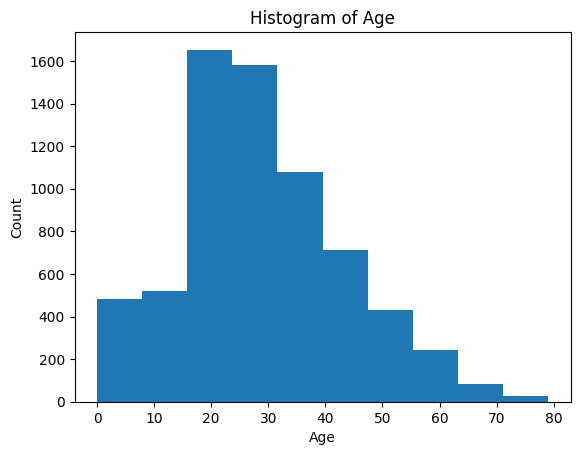

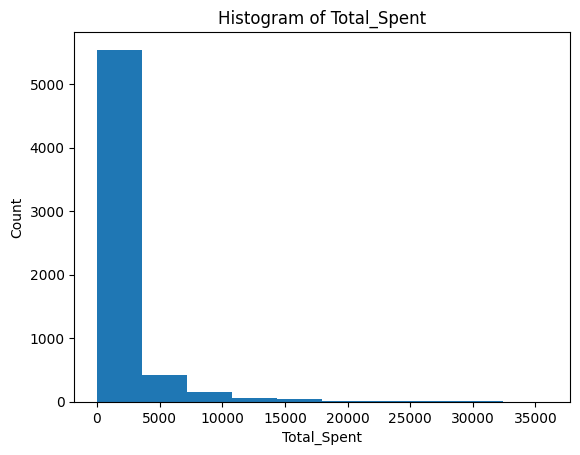

In [25]:
for col in numeric_columns:
    X_train[col].plot(kind="hist")
    plt.title(f"Histogram of {col}")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.show()
    


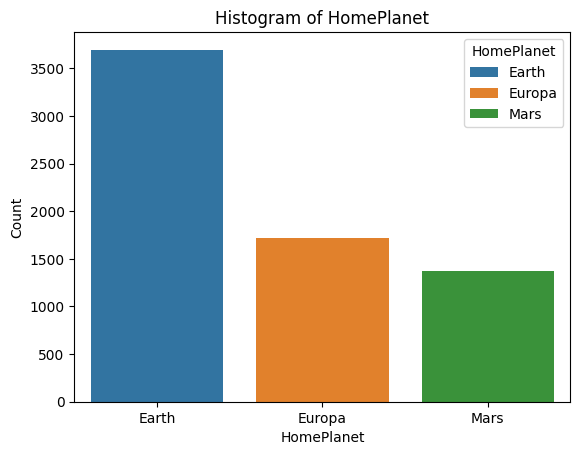

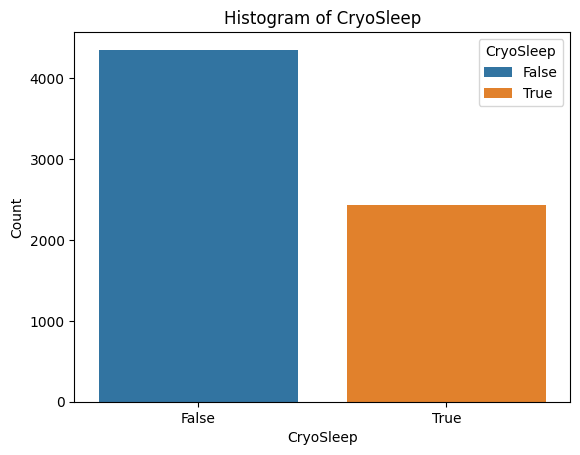

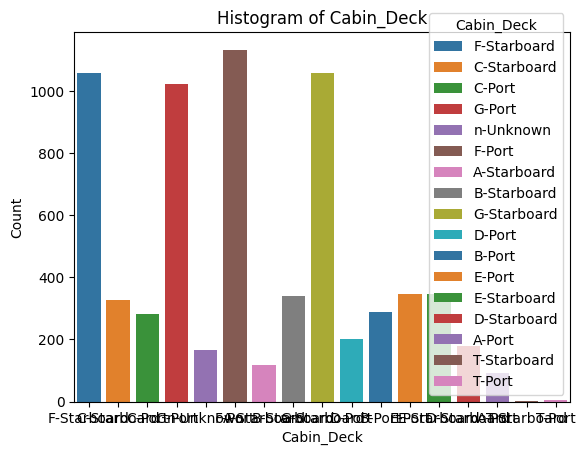

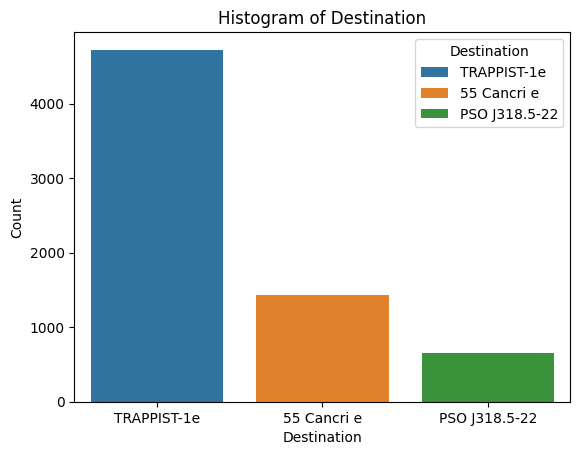

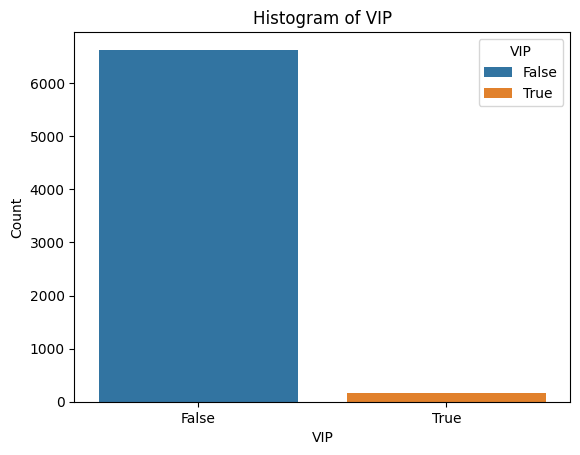

In [26]:
for col in categorical_columns:
    sns.countplot(data=X_train, x=col, palette='tab10', hue=col, legend=True)
    plt.title(f"Histogram of {col}")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.show()
    

#### Day 1 done - early exploration and data understanding. eta time spent: 45min

### Data Cleaning

In [27]:
df_train = pd.concat((X_train, y_train), axis=1)
df_train.shape

(6954, 9)

In [28]:
df_train[categorical_columns].isna().sum()

HomePlanet     167
CryoSleep      166
Cabin_Deck       0
Destination    142
VIP            161
dtype: int64

In [29]:
pct_vip_transported = df_train[df_train["VIP"] == True]["Transported"].sum() / df_train[df_train["VIP"] == True].shape[0]
pct_vip_transported

0.391304347826087

In [30]:
pct_nonvip_transported = df_train[df_train["VIP"] == False]["Transported"].sum() / df_train[df_train["VIP"] == False].shape[0]
pct_nonvip_transported

0.502714113389626

<Axes: xlabel='HomePlanet'>

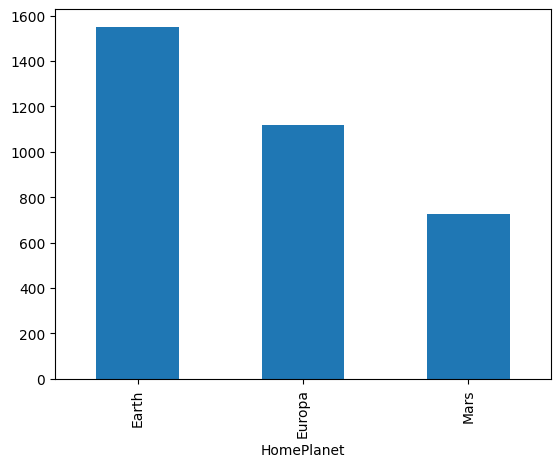

In [31]:
df_train.groupby("HomePlanet")["Transported"].sum().plot(kind='bar')

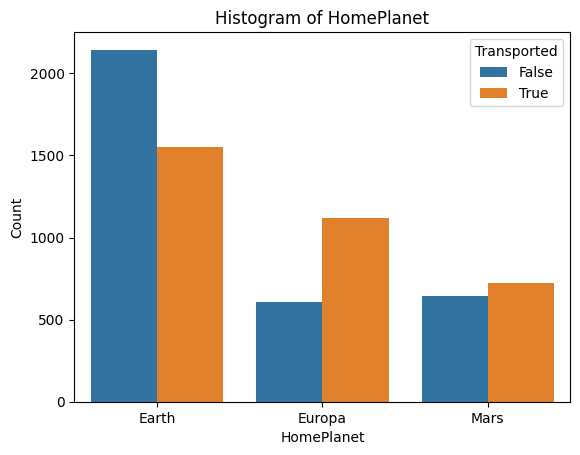

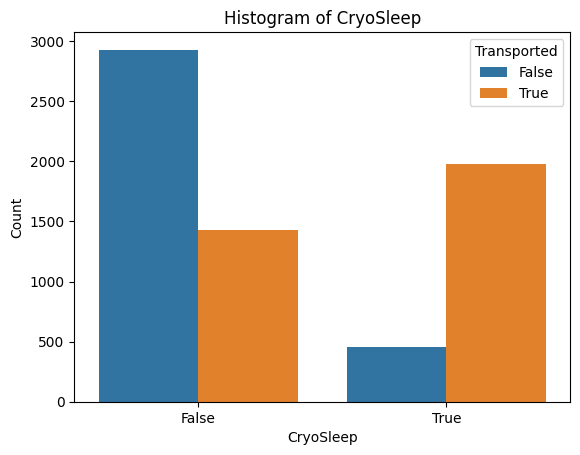

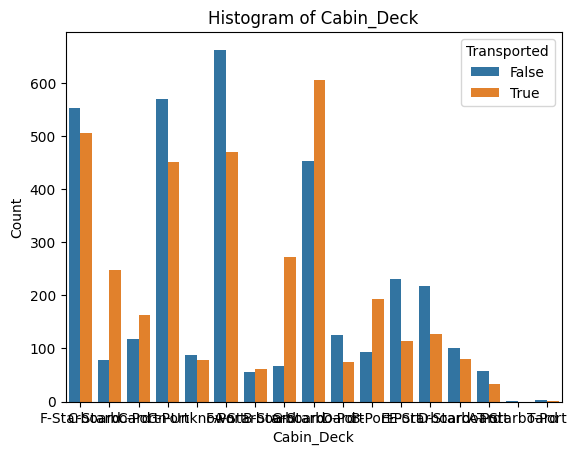

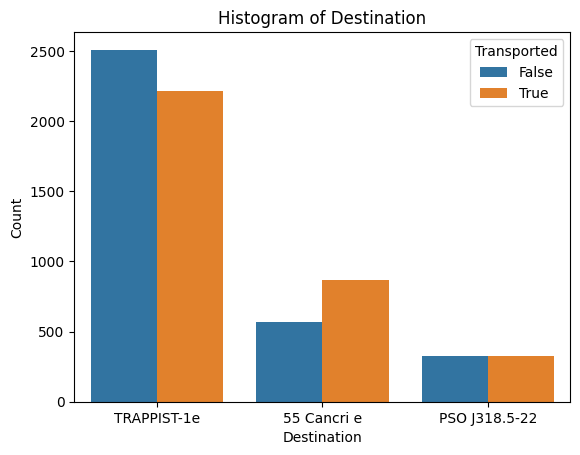

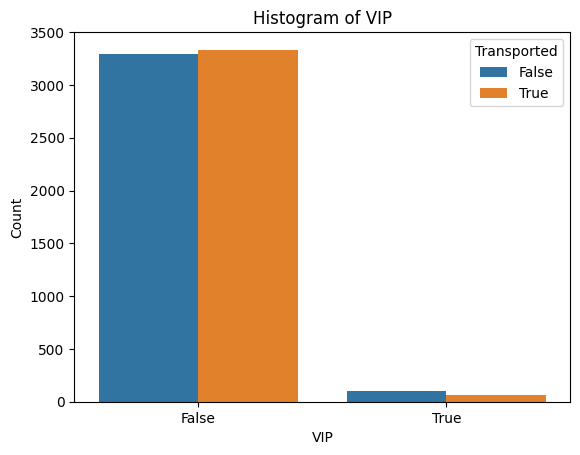

In [32]:
for col in categorical_columns:
    sns.countplot(data=df_train, x=col, palette='tab10', hue="Transported", legend=True)
    plt.title(f"Histogram of {col}")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.show()

## NA values handling

#### Based on plots:
1. We can safely add "False" as default data to **VIP** column, as there is no significant difference.



In [33]:
df_train[categorical_columns].isna().sum()

HomePlanet     167
CryoSleep      166
Cabin_Deck       0
Destination    142
VIP            161
dtype: int64

In [34]:
df_train["VIP"] = df_train["VIP"].fillna("False")
df_train["VIP"].isna().sum()


0

## To future self:
If i had enough time to handle this, the best approach would be: count the median for people of NA, eg. 'HomePlanet', see other important columns like 'CryoSleep', "Destination" and "Transported" - and based on this evaluate and fill those missing values. But since this is a training task and the model is no going to production (well at least I hope there wont be any space titanic disasters in the near future) I shall go with the easiest approach -> fill up all the missing values with mode. I wont be deleting them, because there is little data.

In [35]:
mode_planet = df_train["HomePlanet"].mode()[0]
mode_cryo = df_train["CryoSleep"].mode()[0]
mode_destination = df_train["Destination"].mode()[0]

mode_planet

'Earth'

In [36]:
df_train["HomePlanet"] = df_train["HomePlanet"].fillna(mode_planet)
df_train["CryoSleep"] = df_train["CryoSleep"].fillna(mode_cryo)
df_train["Destination"] = df_train["Destination"].fillna(mode_destination)


C:\Users\USER\AppData\Local\Temp\ipykernel_6696\2601116422.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train["CryoSleep"] = df_train["CryoSleep"].fillna(mode_cryo)


In [37]:
df_train[categorical_columns].isna().sum()

HomePlanet     0
CryoSleep      0
Cabin_Deck     0
Destination    0
VIP            0
dtype: int64

In [38]:
df_train.isna().sum()

HomePlanet       0
CryoSleep        0
Destination      0
Age            144
VIP              0
Grouped          0
Cabin_Deck       0
Total_Spent    717
Transported      0
dtype: int64

### Based on the plots -> most frequent value in spendings was 0 -> that's why im using it to fill NA in numeric columns

In [39]:
df_train["Total_Spent"] = df_train["Total_Spent"].fillna(0)


In [40]:
df_train.isna().sum()

HomePlanet       0
CryoSleep        0
Destination      0
Age            144
VIP              0
Grouped          0
Cabin_Deck       0
Total_Spent      0
Transported      0
dtype: int64

In [41]:
df_train["Age"] = df_train["Age"].fillna(df_train["Age"].median())
df_train.isna().sum()

HomePlanet     0
CryoSleep      0
Destination    0
Age            0
VIP            0
Grouped        0
Cabin_Deck     0
Total_Spent    0
Transported    0
dtype: int64

#Applying all the logic from before to X_val

In [42]:
X_val.head(1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
1729,1843_01,Europa,False,E/112/P,TRAPPIST-1e,46.0,False,2249.0,153.0,137.0,NaN,194.0


In [43]:
X_val["Prefix"] = X_val["PassengerId"].apply(get_prefix)
X_val["Grouped"] = X_val["Prefix"].duplicated(keep=False)
X_val = X_val.drop(columns=["PassengerId", "Prefix"]).copy()

In [44]:
X_val["Deck"] = X_val["Cabin"].apply(dummy)
X_val["Cabin"] = X_val["Cabin"].apply(get_cabin)


In [45]:
X_val["Cabin_Deck"] = X_val["Deck"] + "-" + X_val["Cabin"]
X_val = X_val.drop(columns=["Cabin", "Deck"])

In [46]:
X_val["Total_Spent"] = X_val["RoomService"] + X_val["FoodCourt"] + X_val["ShoppingMall"] + X_val["Spa"] + X_val["VRDeck"]

X_val = X_val.drop(columns=["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"])

In [47]:
## NA VALUES based on train

X_val["VIP"] = X_val["VIP"].fillna("False")

In [48]:
X_val["HomePlanet"] = X_val["HomePlanet"].fillna(mode_planet)
X_val["CryoSleep"] = X_val["CryoSleep"].fillna(mode_cryo)
X_val["Destination"] = X_val["Destination"].fillna(mode_destination)

C:\Users\USER\AppData\Local\Temp\ipykernel_6696\1601733807.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_val["CryoSleep"] = X_val["CryoSleep"].fillna(mode_cryo)


In [49]:
X_val["Total_Spent"] = X_val["Total_Spent"].fillna(0)

In [50]:
X_val["Age"] =X_val["Age"].fillna(df_train["Age"].median())

In [51]:
X_train.shape, X_val.shape, df_train.shape

((6954, 8), (1739, 8), (6954, 9))

### Encoding and Preparing for Training

In [52]:
X_train = df_train.drop("Transported", axis=1)
y_train = df_train["Transported"]

##for safety purposes

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])

In [54]:
X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])

In [55]:
X_train.head(1)

,HomePlanet,CryoSleep,Destination,Age,VIP,Grouped,Cabin_Deck,Total_Spent
4049,Earth,False,TRAPPIST-1e,-0.610154,False,False,F-Starboard,-0.161293


In [56]:
X_val.head(1)

,HomePlanet,CryoSleep,Destination,Age,VIP,Grouped,Cabin_Deck,Total_Spent
1729,Europa,False,TRAPPIST-1e,1.191314,False,False,E-Port,-0.48914


In [57]:
X_train["VIP"] = X_train["VIP"].map({True: 1, False: 0})
X_val["VIP"] = X_val["VIP"].map({True:1, False:0})

In [58]:
X_train.head(1)

,HomePlanet,CryoSleep,Destination,Age,VIP,Grouped,Cabin_Deck,Total_Spent
4049,Earth,False,TRAPPIST-1e,-0.610154,0.0,False,F-Starboard,-0.161293


#### Note: Maybe cabin_deck isnt ideal for now - shall be tested in the future. Will see how the model will perform. Probably can drop either starboard/port shape, or the Deck shape. 

In [59]:
from sklearn.preprocessing import OneHotEncoder
cols_to_encode = ["HomePlanet", "Destination", "Cabin_Deck"]
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe.fit(X_train[cols_to_encode])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [60]:


X_ohe_train = pd.DataFrame(ohe.transform(X_train[cols_to_encode]),
                           columns=ohe.get_feature_names_out(cols_to_encode),
                           index=X_train.index)

X_train_full = pd.concat([X_train.drop(columns=cols_to_encode), X_ohe_train], axis=1)

In [ ]:


X_ohe_val = pd.DataFrame(ohe.transform(X_val[cols_to_encode]),
                           columns=ohe.get_feature_names_out(cols_to_encode),
                           index=X_val.index)

X_val_full = pd.concat([X_val.drop(columns=cols_to_encode), X_ohe_val], axis=1)

### Model Training

In [62]:
y_train.value_counts() #no imbalance within classes

Transported
True     3479
False    3475
Name: count, dtype: int64

In [63]:
X_train_full["VIP"] = X_train_full["VIP"].fillna(0)
X_train_full.isna().sum()

CryoSleep                    0
Age                          0
VIP                          0
Grouped                      0
Total_Spent                  0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
Cabin_Deck_A-Port            0
Cabin_Deck_A-Starboard       0
Cabin_Deck_B-Port            0
Cabin_Deck_B-Starboard       0
Cabin_Deck_C-Port            0
Cabin_Deck_C-Starboard       0
Cabin_Deck_D-Port            0
Cabin_Deck_D-Starboard       0
Cabin_Deck_E-Port            0
Cabin_Deck_E-Starboard       0
Cabin_Deck_F-Port            0
Cabin_Deck_F-Starboard       0
Cabin_Deck_G-Port            0
Cabin_Deck_G-Starboard       0
Cabin_Deck_T-Port            0
Cabin_Deck_T-Starboard       0
Cabin_Deck_n-Unknown         0
dtype: int64

In [64]:
X_val_full["VIP"] = X_val_full["VIP"].fillna(0)
X_val_full.isna().sum()

CryoSleep                    0
Age                          0
VIP                          0
Grouped                      0
Total_Spent                  0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
Cabin_Deck_A-Port            0
Cabin_Deck_A-Starboard       0
Cabin_Deck_B-Port            0
Cabin_Deck_B-Starboard       0
Cabin_Deck_C-Port            0
Cabin_Deck_C-Starboard       0
Cabin_Deck_D-Port            0
Cabin_Deck_D-Starboard       0
Cabin_Deck_E-Port            0
Cabin_Deck_E-Starboard       0
Cabin_Deck_F-Port            0
Cabin_Deck_F-Starboard       0
Cabin_Deck_G-Port            0
Cabin_Deck_G-Starboard       0
Cabin_Deck_T-Port            0
Cabin_Deck_T-Starboard       0
Cabin_Deck_n-Unknown         0
dtype: int64

## LR

In [65]:
model_lr = LogisticRegression()
model_lr.fit(X_train_full, y_train)

y_pred = model_lr.predict(X_val_full)
y_pred_train = model_lr.predict(X_train_full)

class_report_train = classification_report(y_true=y_train, y_pred=y_pred_train)
class_report_val = classification_report(y_true=y_val, y_pred=y_pred)

print(class_report_train)
print("*"*30)
print(class_report_val)

              precision    recall  f1-score   support

       False       0.70      0.82      0.76      3475
        True       0.78      0.66      0.71      3479

    accuracy                           0.74      6954
   macro avg       0.74      0.74      0.74      6954
weighted avg       0.74      0.74      0.74      6954

******************************
              precision    recall  f1-score   support

       False       0.68      0.83      0.75       840
        True       0.80      0.63      0.70       899

    accuracy                           0.73      1739
   macro avg       0.74      0.73      0.73      1739
weighted avg       0.74      0.73      0.72      1739



## XGB

In [66]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_full, y_train)

y_pred_xgb = model_xgb.predict(X_val_full)
y_pred_train_xgb = model_xgb.predict(X_train_full)

class_report_train_xgb = classification_report(y_true=y_train, y_pred=y_pred_train_xgb)
class_report_val_xgb = classification_report(y_true=y_val, y_pred=y_pred_xgb)

print(class_report_train_xgb)
print("*"*30)
print(class_report_val_xgb)

              precision    recall  f1-score   support

       False       0.80      0.89      0.84      3475
        True       0.88      0.78      0.83      3479

    accuracy                           0.84      6954
   macro avg       0.84      0.84      0.84      6954
weighted avg       0.84      0.84      0.84      6954

******************************
              precision    recall  f1-score   support

       False       0.69      0.84      0.76       840
        True       0.81      0.65      0.72       899

    accuracy                           0.74      1739
   macro avg       0.75      0.74      0.74      1739
weighted avg       0.75      0.74      0.74      1739



## Note: day 2 - break, overall time spent: 2:30 (45+1h45m)

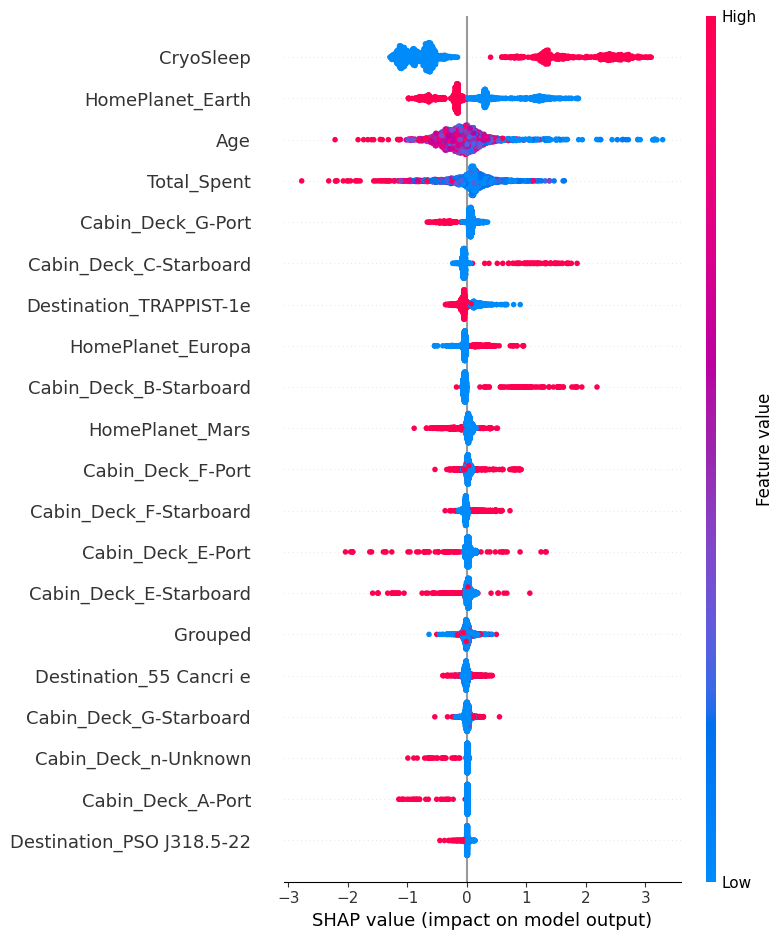

In [67]:
import shap


explainer = shap.Explainer(model_xgb)
shap_values = explainer.shap_values(X_val_full)
shap.summary_plot(shap_values, X_val_full)

### Optuna for XGB

In [69]:
import optuna
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score

In [70]:
def objective(trial):
    params = {
       'objective' : "binary:logistic",
       "eval_metric":"logloss",
       "verbosity" : 0,
       "booster" : "gbtree",
       "lambda" : trial.suggest_float("lambda", 1e-3,10.0,log=True),
       "alpha" : trial.suggest_float("alpha", 1e-3, 10.0, log=True),
       "subsample" : trial.suggest_float("subsample", 0.4, 1.0),
       "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.4,1.0),
       "max_depth" : trial.suggest_int("max_depth", 3,10),
       "eta" : trial.suggest_float( "eta", 0.01, 0.3),
       "gamma" : trial.suggest_float("gamma", 0, 10),
       "scale_pos_weight" : trial.suggest_float('scale_pos_weight', 1,10),
       "min_child_weight" : trial.suggest_int("min_child_weight", 1, 10),
       "max_delta_step" : trial.suggest_int("max_delta_step", 0,10)
    }
    
    model = XGBClassifier(**params)
    
    f1_scorer = make_scorer(f1_score, average="macro")
    scores = cross_val_score(model, X_train_full, y_train, cv=5, scoring=f1_scorer, n_jobs=-1)
    
    return np.mean(scores)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective, n_trials=20)

[I 2025-06-12 07:29:45,378] A new study created in memory with name: no-name-7b01f20e-b3a5-49b3-bf80-c388217c21f5
[I 2025-06-12 07:29:47,337] Trial 0 finished with value: 0.42313880892786093 and parameters: {'lambda': 0.252627342011498, 'alpha': 0.6249617222815037, 'subsample': 0.660579811382138, 'colsample_bytree': 0.8996554278735953, 'max_depth': 10, 'eta': 0.12233067223446856, 'gamma': 5.9628176016646535, 'scale_pos_weight': 6.216210180389969, 'min_child_weight': 8, 'max_delta_step': 8}. Best is trial 0 with value: 0.42313880892786093.
[I 2025-06-12 07:29:48,683] Trial 1 finished with value: 0.3676291967430407 and parameters: {'lambda': 0.7666268837231607, 'alpha': 0.7160624344572464, 'subsample': 0.9580374488017728, 'colsample_bytree': 0.6734819131979166, 'max_depth': 5, 'eta': 0.05001716432852361, 'gamma': 2.0640572966511628, 'scale_pos_weight': 5.557252215928838, 'min_child_weight': 3, 'max_delta_step': 7}. Best is trial 0 with value: 0.42313880892786093.
[I 2025-06-12 07:29:50,0

In [71]:
print("Best trial:")
trial_xgb = study_xgb.best_trial
print(f"F1 score: {trial_xgb.value}")
print("Params :")
for key, value in trial_xgb.params.items():
    print(" {}:{}".format(key, value))
    
best_model_xgb = XGBClassifier(**study_xgb.best_params)
best_model_xgb.fit(X_train_full, y_train)

y_pred_best_model_xgb = best_model_xgb.predict(X_val_full)

print(classification_report(y_pred=y_pred_best_model_xgb, y_true=y_val))

Best trial:
F1 score: 0.7395549593109954
Params :
 lambda:0.0016038807624424078
 alpha:9.461372264164387
 subsample:0.439669708177556
 colsample_bytree:0.4095699247890823
 max_depth:7
 eta:0.2986886284951275
 gamma:0.04922091258291328
 scale_pos_weight:1.0442237377841108
 min_child_weight:1
 max_delta_step:10
              precision    recall  f1-score   support

       False       0.68      0.85      0.75       840
        True       0.81      0.63      0.71       899

    accuracy                           0.73      1739
   macro avg       0.75      0.74      0.73      1739
weighted avg       0.75      0.73      0.73      1739



#### Saving to ML flow

In [72]:
import mlflow

In [73]:
report_dict = classification_report(y_pred=y_pred_best_model_xgb, y_true=y_val,output_dict=True)
params = study_xgb.best_params

In [77]:
report_dict

{'False': {'precision': 0.6820365033621518,
  'recall': 0.8452380952380952,
  'f1-score': 0.7549175970228602,
  'support': 840.0},
 'True': {'precision': 0.8137535816618912,
  'recall': 0.6318131256952169,
  'f1-score': 0.7113337507827175,
  'support': 899.0},
 'accuracy': 0.7349051178838413,
 'macro avg': {'precision': 0.7478950425120214,
  'recall': 0.738525610466656,
  'f1-score': 0.7331256739027889,
  'support': 1739.0},
 'weighted avg': {'precision': 0.7501294610340701,
  'recall': 0.7349051178838413,
  'f1-score': 0.7323863274599572,
  'support': 1739.0}}

In [83]:
mlflow.set_experiment("Spaceship")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")

with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_metrics({
        'accuracy': report_dict['accuracy'],
        'recall_class_0': report_dict['False']['recall'],
        'recall_class_1': report_dict['True']['recall'],
        'f1_score_macro': report_dict['macro avg']['f1-score']
    })
    mlflow.sklearn.log_model(best_model_xgb, "XGB")  

2025/06/12 07:43:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run lyrical-colt-825 at: http://127.0.0.1:5000/#/experiments/113737786824616722/runs/ae3e5756ac26477eab77f978a5718e9d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/113737786824616722


### Another approach: Will delete some of the noisy classes, depending on the last SHAP outcome

In [84]:
#time left to finish project atm: 1.5h

In [85]:
X_train_full.columns

Index(['CryoSleep', 'Age', 'VIP', 'Grouped', 'Total_Spent', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e',
       'Cabin_Deck_A-Port', 'Cabin_Deck_A-Starboard', 'Cabin_Deck_B-Port',
       'Cabin_Deck_B-Starboard', 'Cabin_Deck_C-Port', 'Cabin_Deck_C-Starboard',
       'Cabin_Deck_D-Port', 'Cabin_Deck_D-Starboard', 'Cabin_Deck_E-Port',
       'Cabin_Deck_E-Starboard', 'Cabin_Deck_F-Port', 'Cabin_Deck_F-Starboard',
       'Cabin_Deck_G-Port', 'Cabin_Deck_G-Starboard', 'Cabin_Deck_T-Port',
       'Cabin_Deck_T-Starboard', 'Cabin_Deck_n-Unknown'],
      dtype='object')

In [86]:
X_train_full = X_train_full.drop(columns=["Destination_PSO J318.5-22", "Cabin_Deck_A-Port", "Cabin_Deck_n-Unknown", "Cabin_Deck_G-Starboard", "Destination_55 Cancri e"]).copy()
X_val_full = X_val_full.drop(columns=["Destination_PSO J318.5-22", "Cabin_Deck_A-Port", "Cabin_Deck_n-Unknown", "Cabin_Deck_G-Starboard", "Destination_55 Cancri e"]).copy()

#### models retrain and revalidation using simple trial and error

In [87]:
model_xgb_1 = XGBClassifier()
model_xgb_1.fit(X_train_full, y_train)

y_pred_xgb_1 = model_xgb_1.predict(X_val_full)
y_pred_train_xgb_1 = model_xgb_1.predict(X_train_full)

class_report_train_xgb_1 = classification_report(y_true=y_train, y_pred=y_pred_train_xgb_1)
class_report_val_xgb_1 = classification_report(y_true=y_val, y_pred=y_pred_xgb_1)

print(class_report_train_xgb_1)
print("*"*30)
print(class_report_val_xgb_1)

              precision    recall  f1-score   support

       False       0.80      0.89      0.85      3475
        True       0.88      0.78      0.83      3479

    accuracy                           0.84      6954
   macro avg       0.84      0.84      0.84      6954
weighted avg       0.84      0.84      0.84      6954

******************************
              precision    recall  f1-score   support

       False       0.69      0.83      0.75       840
        True       0.81      0.65      0.72       899

    accuracy                           0.74      1739
   macro avg       0.75      0.74      0.74      1739
weighted avg       0.75      0.74      0.74      1739



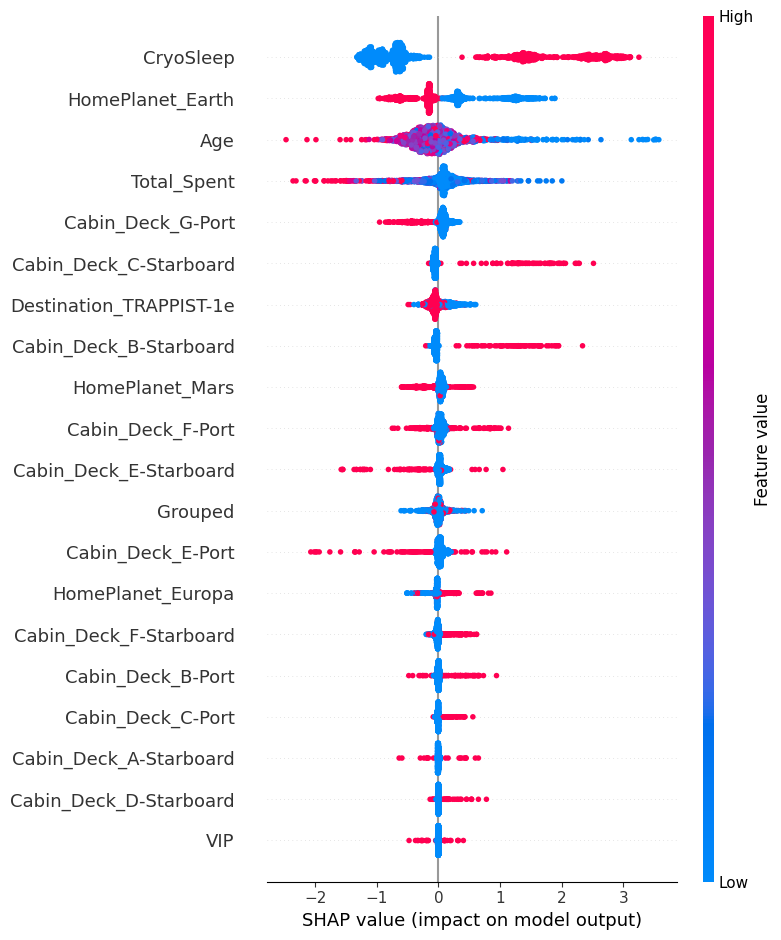

In [89]:

explainer = shap.Explainer(model_xgb_1)
shap_values = explainer.shap_values(X_val_full)
shap.summary_plot(shap_values, X_val_full)

In [91]:
X_train_full = X_train_full.drop(columns=["VIP", "Cabin_Deck_A-Starboard", "Cabin_Deck_D-Starboard", "Cabin_Deck_B-Port", "Cabin_Deck_C-Port", "Cabin_Deck_F-Starboard", "Cabin_Deck_E-Port"]).copy()
X_val_full = X_val_full.drop(columns=["VIP", "Cabin_Deck_A-Starboard", "Cabin_Deck_D-Starboard", "Cabin_Deck_B-Port", "Cabin_Deck_C-Port", "Cabin_Deck_F-Starboard", "Cabin_Deck_E-Port"]).copy()

In [92]:
X_train_full.columns

Index(['CryoSleep', 'Age', 'Grouped', 'Total_Spent', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_TRAPPIST-1e',
       'Cabin_Deck_B-Starboard', 'Cabin_Deck_C-Starboard', 'Cabin_Deck_D-Port',
       'Cabin_Deck_E-Starboard', 'Cabin_Deck_F-Port', 'Cabin_Deck_G-Port',
       'Cabin_Deck_T-Port', 'Cabin_Deck_T-Starboard'],
      dtype='object')

In [93]:
model_xgb_2 = XGBClassifier()
model_xgb_2.fit(X_train_full, y_train)

y_pred_xgb_2 = model_xgb_2.predict(X_val_full)
y_pred_train_xgb_2 = model_xgb_2.predict(X_train_full)

class_report_train_xgb_2 = classification_report(y_true=y_train, y_pred=y_pred_train_xgb_2)
class_report_val_xgb_2 = classification_report(y_true=y_val, y_pred=y_pred_xgb_2)

print(class_report_train_xgb_2)
print("*"*30)
print(class_report_val_xgb_2)

              precision    recall  f1-score   support

       False       0.79      0.88      0.83      3475
        True       0.86      0.77      0.81      3479

    accuracy                           0.82      6954
   macro avg       0.83      0.82      0.82      6954
weighted avg       0.83      0.82      0.82      6954

******************************
              precision    recall  f1-score   support

       False       0.69      0.83      0.75       840
        True       0.80      0.65      0.72       899

    accuracy                           0.74      1739
   macro avg       0.75      0.74      0.73      1739
weighted avg       0.75      0.74      0.73      1739



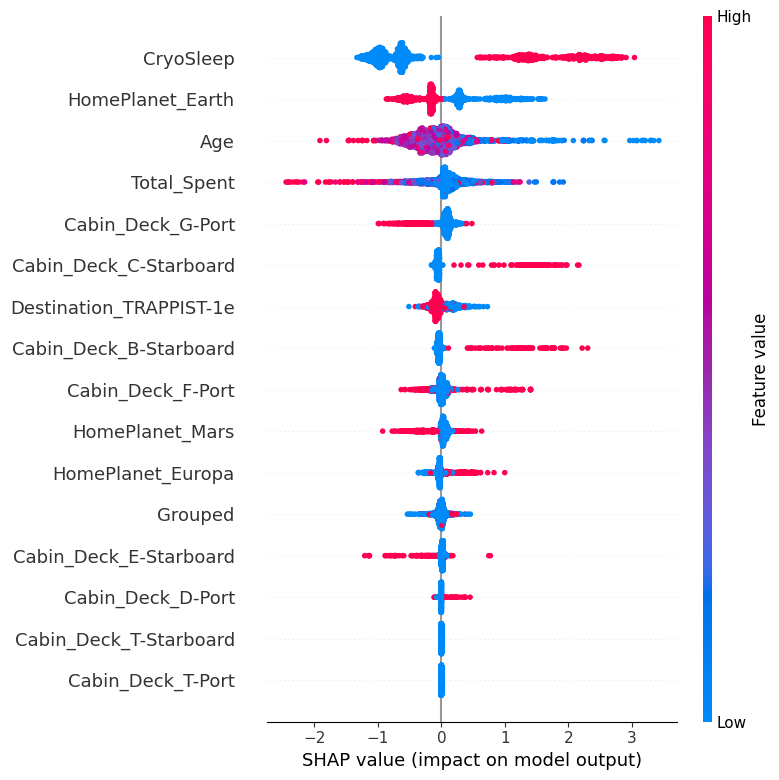

In [94]:

explainer = shap.Explainer(model_xgb_2)
shap_values = explainer.shap_values(X_val_full)
shap.summary_plot(shap_values, X_val_full)

In [96]:
X_train_full = X_train_full.drop(columns=["Cabin_Deck_T-Port", 'Cabin_Deck_T-Starboard', "Cabin_Deck_D-Port", "Cabin_Deck_E-Starboard", "HomePlanet_Mars", "HomePlanet_Europa"]).copy()
X_val_full = X_val_full.drop(columns=["Cabin_Deck_T-Port", 'Cabin_Deck_T-Starboard', "Cabin_Deck_D-Port", "Cabin_Deck_E-Starboard", "HomePlanet_Mars", "HomePlanet_Europa"]).copy()

In [97]:
X_train_full.columns

Index(['CryoSleep', 'Age', 'Grouped', 'Total_Spent', 'HomePlanet_Earth',
       'Destination_TRAPPIST-1e', 'Cabin_Deck_B-Starboard',
       'Cabin_Deck_C-Starboard', 'Cabin_Deck_F-Port', 'Cabin_Deck_G-Port'],
      dtype='object')

In [98]:
model_xgb_3 = XGBClassifier()
model_xgb_3.fit(X_train_full, y_train)

y_pred_xgb_3 = model_xgb_3.predict(X_val_full)
y_pred_train_xgb_3 = model_xgb_3.predict(X_train_full)

class_report_train_xgb_3 = classification_report(y_true=y_train, y_pred=y_pred_train_xgb_3)
class_report_val_xgb_3 = classification_report(y_true=y_val, y_pred=y_pred_xgb_3)

print(class_report_train_xgb_3)
print("*"*30)
print(class_report_val_xgb_3)

              precision    recall  f1-score   support

       False       0.79      0.88      0.83      3475
        True       0.86      0.77      0.81      3479

    accuracy                           0.82      6954
   macro avg       0.83      0.82      0.82      6954
weighted avg       0.83      0.82      0.82      6954

******************************
              precision    recall  f1-score   support

       False       0.68      0.82      0.75       840
        True       0.79      0.65      0.71       899

    accuracy                           0.73      1739
   macro avg       0.74      0.73      0.73      1739
weighted avg       0.74      0.73      0.73      1739



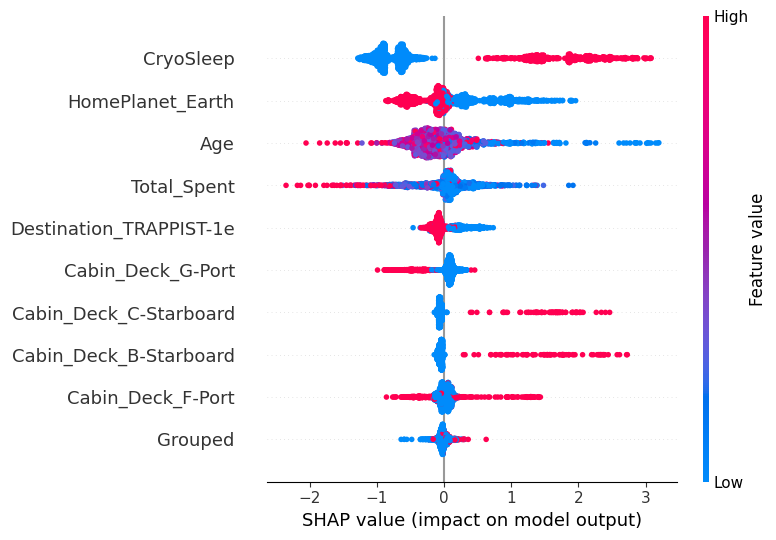

In [99]:

explainer = shap.Explainer(model_xgb_3)
shap_values = explainer.shap_values(X_val_full)
shap.summary_plot(shap_values, X_val_full)

In [101]:
X_train_full = X_train_full.drop(columns=["Cabin_Deck_F-Port", "Cabin_Deck_B-Starboard", "Cabin_Deck_C-Starboard", "Cabin_Deck_G-Port", "Destination_TRAPPIST-1e", "Grouped"]).copy()
X_val_full = X_val_full.drop(columns=["Cabin_Deck_F-Port", "Cabin_Deck_B-Starboard", "Cabin_Deck_C-Starboard", "Cabin_Deck_G-Port", "Destination_TRAPPIST-1e", "Grouped"]).copy()

In [102]:
X_train_full.columns

Index(['CryoSleep', 'Age', 'Total_Spent', 'HomePlanet_Earth'], dtype='object')

In [103]:
model_xgb_4 = XGBClassifier()
model_xgb_4.fit(X_train_full, y_train)

y_pred_xgb_4 = model_xgb_4.predict(X_val_full)
y_pred_train_xgb_4 = model_xgb_4.predict(X_train_full)

class_report_train_xgb_4 = classification_report(y_true=y_train, y_pred=y_pred_train_xgb_4)
class_report_val_xgb_4 = classification_report(y_true=y_val, y_pred=y_pred_xgb_4)

print(class_report_train_xgb_4)
print("*"*30)
print(class_report_val_xgb_4)

              precision    recall  f1-score   support

       False       0.76      0.85      0.80      3475
        True       0.83      0.73      0.78      3479

    accuracy                           0.79      6954
   macro avg       0.80      0.79      0.79      6954
weighted avg       0.80      0.79      0.79      6954

******************************
              precision    recall  f1-score   support

       False       0.68      0.79      0.73       840
        True       0.77      0.65      0.71       899

    accuracy                           0.72      1739
   macro avg       0.72      0.72      0.72      1739
weighted avg       0.73      0.72      0.72      1739



In [104]:
model_lr = LogisticRegression()
model_lr.fit(X_train_full, y_train)

y_pred = model_lr.predict(X_val_full)
y_pred_train = model_lr.predict(X_train_full)

class_report_train = classification_report(y_true=y_train, y_pred=y_pred_train)
class_report_val = classification_report(y_true=y_val, y_pred=y_pred)

print(class_report_train)
print("*"*30)
print(class_report_val)

              precision    recall  f1-score   support

       False       0.68      0.85      0.76      3475
        True       0.81      0.60      0.69      3479

    accuracy                           0.73      6954
   macro avg       0.74      0.73      0.72      6954
weighted avg       0.74      0.73      0.72      6954

******************************
              precision    recall  f1-score   support

       False       0.67      0.86      0.75       840
        True       0.82      0.60      0.69       899

    accuracy                           0.73      1739
   macro avg       0.75      0.73      0.72      1739
weighted avg       0.75      0.73      0.72      1739



In [ ]:
#model_xgb_1 -> best performing model

In [105]:
class_report_train_xgb_1 = classification_report(y_true=y_train, y_pred=y_pred_train_xgb_1)
class_report_val_xgb_1 = classification_report(y_true=y_val, y_pred=y_pred_xgb_1)

print(class_report_train_xgb_1)
print("*"*30)
print(class_report_val_xgb_1)

              precision    recall  f1-score   support

       False       0.80      0.89      0.85      3475
        True       0.88      0.78      0.83      3479

    accuracy                           0.84      6954
   macro avg       0.84      0.84      0.84      6954
weighted avg       0.84      0.84      0.84      6954

******************************
              precision    recall  f1-score   support

       False       0.69      0.83      0.75       840
        True       0.81      0.65      0.72       899

    accuracy                           0.74      1739
   macro avg       0.75      0.74      0.74      1739
weighted avg       0.75      0.74      0.74      1739



### test - performing all the transforming on test data without any fitting

In [139]:
df_test = pd.read_csv("data\\test.csv")

In [140]:
df_test["Prefix"] = df_test["PassengerId"].apply(get_prefix)
df_test["Grouped"] = df_test["Prefix"].duplicated(keep=False)
df_test = df_test.drop(columns=["Prefix"]).copy()

In [141]:
df_test ["Deck"] = df_test ["Cabin"].apply(dummy)
df_test ["Cabin"] = df_test ["Cabin"].apply(get_cabin)

In [142]:

df_test["Cabin_Deck"] = df_test["Deck"] + "-" + df_test["Cabin"]
df_test = df_test.drop(columns=["Cabin", "Deck"])

In [143]:
df_test["Total_Spent"] = df_test["RoomService"] + df_test["FoodCourt"] + df_test["ShoppingMall"] + df_test["Spa"] + df_test["VRDeck"]

In [144]:
df_test = df_test.drop(columns=["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"])

In [145]:
df_test["VIP"] = df_test["VIP"].fillna("False")

In [146]:

df_test["VIP"] = df_test["VIP"].map({True:1, False:0})

In [147]:

df_test["VIP"] = df_test["VIP"].fillna(0)

In [148]:
df_test["HomePlanet"] = df_test["HomePlanet"].fillna(mode_planet)
df_test["CryoSleep"] = df_test["CryoSleep"].fillna(mode_cryo)
df_test["Destination"] = df_test["Destination"].fillna(mode_destination)

C:\Users\USER\AppData\Local\Temp\ipykernel_6696\892048721.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test["CryoSleep"] = df_test["CryoSleep"].fillna(mode_cryo)


In [149]:
df_test["Total_Spent"] = df_test["Total_Spent"].fillna(0)

In [150]:

df_test["Age"] =df_test["Age"].fillna(df_train["Age"].median())

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Name,Grouped,Cabin_Deck,Total_Spent
0,0013_01,Earth,True,TRAPPIST-1e,27.0,0.0,Nelly Carsoning,False,G-Starboard,0.0


In [152]:
df_test[numeric_columns] = scaler.transform(df_test[numeric_columns])

In [153]:
X_ohe_test = pd.DataFrame(ohe.transform(df_test[cols_to_encode]),
                           columns=ohe.get_feature_names_out(cols_to_encode),
                           index=df_test.index)

X_test_full = pd.concat([df_test.drop(columns=cols_to_encode), X_ohe_test], axis=1)

In [154]:
X_test_full = X_test_full.drop(columns=["Destination_PSO J318.5-22", "Cabin_Deck_A-Port", "Cabin_Deck_n-Unknown", "Cabin_Deck_G-Starboard", "Destination_55 Cancri e"]).copy()

In [155]:
X_test_full = X_test_full.drop(columns=["Name"]).copy()

In [157]:
X_test_full.head(1)

,PassengerId,CryoSleep,Age,VIP,Grouped,Total_Spent,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_TRAPPIST-1e,...,Cabin_Deck_C-Starboard,Cabin_Deck_D-Port,Cabin_Deck_D-Starboard,Cabin_Deck_E-Port,Cabin_Deck_E-Starboard,Cabin_Deck_F-Port,Cabin_Deck_F-Starboard,Cabin_Deck_G-Port,Cabin_Deck_T-Port,Cabin_Deck_T-Starboard
0,0013_01,True,-0.125143,0.0,False,-0.48914,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
passenger_ids = X_test_full["PassengerId"]


In [159]:
X_test_for_model = X_test_full.drop(columns=["PassengerId"])

In [160]:
y_pred = model_xgb_1.predict(X_test_for_model).astype(int)

In [161]:
submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Transported": y_pred
})

In [164]:
submission["Transported"] = submission["Transported"].map({1: True, 0:False})

In [165]:
submission.head(1)

,PassengerId,Transported
0,0013_01,True


In [166]:
submission.to_csv("submission_tf.csv", index=False)

In [136]:
np.unique(model_xgb_1.predict(X_test_full), return_counts=True)

(array([0, 1]), array([2450, 1827], dtype=int64))

## Summary:
**Time Spent**: around 6h
**Final Test Score on Kaggle**: 0.74
**No AI used for help**

model could be improved a lot, mostly by using different approach to feature engineering, better training using optuna on best model(which I didnt due to lack of time) and a LOT of better data cleaning or different approach to it.

Overall I learned a lot, challenged myself and the score is not so bad. Cheers (to myself from myself.)